# An Exploration Into Quantifying & Analyzing Band Powers of Electroencephography (EEG) Data Based on BrainFlow Library Based Analysis & OpenBCI Cyton Board Datasets
### by Dan Jang

This project focuses on digesting the complex, highly data-verbose nature of electroencephography (EEG) data into readable, visually represented formats (e.g. pretty graphs, visual insights, etc.), for a given end-user of at least a familiarity of numerical analysis to get meaningful insight from.

Electroencephography (EEG) is a non-invasive technique used to record electrical brain activity. Electrodes are placed on the scalp of the brain that measure microcurrents (uVrms).

Primarily, we will be focusing on categorizing the brain waves as:

* Alpha (8-13 Hz) - Alert but relaxed; e.g., eyes are closed or meditation is occuring.
* Beta (13-30 Hz) - Awake and alert; e.g.,
eyes are open and actively thinking.
* Gamma (30-100 Hz) - Higher mental activity, including perception, problem solving, and consciousness (fun fact: lots of "EEG" toys are based on capturing this frequency range as its high enough to be easily captured by cheap sensors)
* Delta (0.5-4 Hz) - Deep sleep
* Theta (4-8 Hz) - which occurs usually during light sleep, deep meditation, and also REM (Rapid Eye Movement) sleep.


In order of increasing frequency (in Hertz \[Hz\]):
1. Delta, from 0.5 to 4 Hz. [Code Segment #2 will use (2, 4) Hz for Delta]
2. Theta, from 4 to 8 Hz.
3. Alpha, from 8 to 13 Hz.
4. Beta, from 13 to 30 Hz.
5. Gamma, from 30 to 100 Hz.  [Code Segment #2 will use (30, 45) Hz for Gamma]


Using graphical analysis, we will process the Band Power of the five brainwaves and see how they change over time. Using such data, we can take a glimpse into brain activity through what activities / state of mind these brain waves may represent, e.g. deep concentrating, or relaxation over a period of time.

We can use the Fast Fourier Transformation (FFT) to categorize these bands for easy viewing.

![OpenBCIInterface](./photos/OpenBCIExampleforPH322Project.png)

For EEG data, I will be using a [OpenBCI Cyton](https://docs.openbci.com/Cyton/CytonLanding/) board, which is a low-cost, open-source, programmable, 8-channel EEG board. The board is connected to a computer via USB, and the data is streamed to the computer via a Python script. The data is then processed and analyzed using Python libraries such as [pyOpenBCI](https://github.com/openbci-archive/pyOpenBCI) and [PyQtGraph](https://www.pyqtgraph.org/).

The EEG headset I will be using to collect the data will feature 8-channel electrodes (based on an electroconductive Ag-AgCl coating), which are placed on the scalp, around areas of the brain that can be associated to specific lobes, e.g. electrodes 1 & 2 represent (pre)frontal cortex/lobes activity.

![OpenBCIHeadset](./photos/OpenBCIHeadsetforPH322Project.webp)

# Dependencies

### Libraries:
* numpy
* matplotlib
* pandas
* brainflow
* logging
* PyQt5==5.15.7
* PyQt5-Qt5==5.15.2
* PyQt5-sip==12.11.0
* pyqtgraph==0.12.4

## Installation / Setup:
To use with a Virtual Environment (e.g. miniconda3), run the following commands to install the above dependencies (if installing them normally did not complete / takes too long / et cetera.):

```bash

pip install logging pyqtgraph numpy matplotlib.pyplot brainflow PyQt5==5.15.7 PyQt5-Qt5==5.15.2 PyQt5-sip==12.11.0 pyqtgraph==0.12.4 IPython
```

# Code Segments

## Code Segment #1: Livestream Plot of EEG Data

Below is a code segment that will livestream a BrainFlow .csv file, containing lines/rows of EEG data, taken from an 8-channel electrode, OpenBCI Cyton Board-based EEG Headset.

We emulate a virtual BrainFlow EEG Board to show the livestreamed .csv file.

### Disclaimer:

* THE FOLLOWING CODE DOES NOT WORK WITHIN JUYPTER NOTEBOOK, BUT WORKS IN A SEPARATE .PY FILE
* CAN BE TESTED BY RUNNING "standalone-1.py" IN standalones FOLDER

##### Demonstration Photo (if ran as standalone):
![standalone-1.py demo](./photos/standalone-1-demo.png)

In [3]:
### PH 322 - OpenBCI & BrainFlow EEG Data Analysis Exploration Project Segment #1: Livestream Display - Dan Jang
## Credits to BrainFlow API Docs for Python File I/O & Band Power Examples

#### THE FOLLOWING CODE DOES NOT WORK WITHIN JUYPTER NOTEBOOK, BUT WORKS IN A SEPARATE .PY FILE
#### CAN BE TESTED BY RUNNING "standalone-1.py" IN standalones FOLDER

## Libraries
#import argparse
import logging
import pyqtgraph as pg
import numpy as np
import matplotlib.pyplot as plt
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, WindowOperations, DetrendOperations
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from pyqtgraph.Qt import QtGui, QtCore

csv_file = "../data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"
#data = np.loadtxt(csv_file, delimiter='\t', skiprows=1)

class Graph:
    def __init__(self, board_shim):
        self.board_id = board_shim.get_board_id()
        self.board_shim = board_shim
        self.exg_channels = BoardShim.get_exg_channels(self.board_id)
        self.sampling_rate = BoardShim.get_sampling_rate(self.board_id)
        self.update_speed_ms = 50
        self.window_size = 4
        self.num_points = self.window_size * self.sampling_rate

        self.app = QtGui.QApplication([])
        self.win = pg.GraphicsWindow(title='BrainFlow Plot', size=(800, 600))

        self._init_timeseries()

        timer = QtCore.QTimer()
        timer.timeout.connect(self.update)
        timer.start(self.update_speed_ms)
        QtGui.QApplication.instance().exec_()

    def _init_timeseries(self):
        self.plots = list()
        self.curves = list()
        for i in range(len(self.exg_channels)):
            p = self.win.addPlot(row=i, col=0)
            p.showAxis('left', False)
            p.setMenuEnabled('left', False)
            p.showAxis('bottom', False)
            p.setMenuEnabled('bottom', False)
            if i == 0:
                p.setTitle('TimeSeries Plot')
            self.plots.append(p)
            curve = p.plot()
            self.curves.append(curve)

    def update(self):
        data = self.board_shim.get_current_board_data(self.num_points)
        for count, channel in enumerate(self.exg_channels):
            # plot timeseries
            DataFilter.detrend(data[channel], DetrendOperations.CONSTANT.value)
            DataFilter.perform_bandpass(data[channel], self.sampling_rate, 3.0, 45.0, 2,
                                        FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
            DataFilter.perform_bandstop(data[channel], self.sampling_rate, 48.0, 52.0, 2,
                                        FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
            DataFilter.perform_bandstop(data[channel], self.sampling_rate, 58.0, 62.0, 2,
                                        FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
            self.curves[count].setData(data[channel].tolist())

        self.app.processEvents()


def main():
    BoardShim.enable_dev_board_logger()
    logging.basicConfig(level=logging.DEBUG)

    # parser = argparse.ArgumentParser()
    # # use docs to check which parameters are required for specific board, e.g. for Cyton - set serial port
    # parser.add_argument('--timeout', type=int, help='timeout for device discovery or connection', required=False,
    #                     default=0)
    # parser.add_argument('--ip-port', type=int, help='ip port', required=False, default=0)
    # parser.add_argument('--ip-protocol', type=int, help='ip protocol, check IpProtocolType enum', required=False,
    #                     default=0)
    # parser.add_argument('--ip-address', type=str, help='ip address', required=False, default='')
    # parser.add_argument('--serial-port', type=str, help='serial port', required=False, default='')
    # parser.add_argument('--mac-address', type=str, help='mac address', required=False, default='')
    # parser.add_argument('--other-info', type=str, help='other info', required=False, default='')
    # parser.add_argument('--streamer-params', type=str, help='streamer params', required=False, default='')
    # parser.add_argument('--serial-number', type=str, help='serial number', required=False, default='')
    # parser.add_argument('--board-id', type=int, help='board id, check docs to get a list of supported boards',
    #                     required=False, default=BoardIds.SYNTHETIC_BOARD)
    # parser.add_argument('--file', type=str, help='file', required=False, default='')
    # parser.add_argument('--master-board', type=int, help='master board id for streaming and playback boards',
    #                     required=False, default=BoardIds.NO_BOARD)
    # args = parser.parse_args()
    
    ## Above is unneeded as we are bypassing arguments via command-line & running with as a virtual board with a pre-set EEG OpenBCI-based BrainFlow-RAW .csv file!

    params = BrainFlowInputParams()
    params.ip_port = 0
    params.serial_port = ''
    params.mac_address = ''
    params.other_info = ''
    params.serial_number = ''
    params.ip_address = ''
    params.ip_protocol = 0
    params.timeout = 0
    params.file = csv_file
    params.master_board = BoardIds.NO_BOARD
    
    defaultboard = BoardIds.SYNTHETIC_BOARD
    streamerparams = ''

    board_shim = BoardShim(defaultboard, params)
    try:
        board_shim.prepare_session()
        board_shim.start_stream(450000, streamerparams)
        Graph(board_shim)
    except BaseException:
        logging.warning('Exception', exc_info=True)
    finally:
        logging.info('End')
        if board_shim.is_prepared():
            logging.info('Releasing session')
            board_shim.release_session()


if __name__ == '__main__':
    main()

C:\Users\Dan\AppData\Local\Temp\ipykernel_38324\1948819766.py:26: DeprecationWarning: GraphicsWindow is deprecated, use GraphicsLayoutWidget instead,will be removed in 0.13
  self.win = pg.GraphicsWindow(title='BrainFlow Plot', size=(800, 600))


## Code Segment #2: EEG Average Band Powers (e.g., Alpha, Beta, Gamma, Delta, Theta brainwaves)

This segment alone took 5 hours to figure out, as there seemed to absolutely no resources on directly taking a .csv EEG dataset file and converting & processing it to be graphable, then graphed as average of band powers over the whole file (vs. all the examples using a livestream example or a direct datastream from the board).

But, alas, the graph was graphed; the graph showcases the Band Powers (in Power - (uV)^2 / Hz) of the five brainwaves, Alpha, Beta, Gamma, Delta, and Theta, over the whole .csv file!

The program below takes around 30 to 60 seconds to run to process a ~250 .csv file, but I will include a smaller .csv file for demonstration purposes.

#### Note:
High deviation can be interpreted most of the time as the .csv file containing a lot of blank data, e.g. headset being taken off & on, headset not being fitted correctly, e.g.

Channels Detected: [0, 1, 2, 3, 4, 5, 6, 7]
Average band powers: [0.64197694 0.24708126 0.06574642 0.04074164 0.00445374]
Standard deviation: [0.57327829 0.57331071 0.60675957 0.61849612 0.60464491]


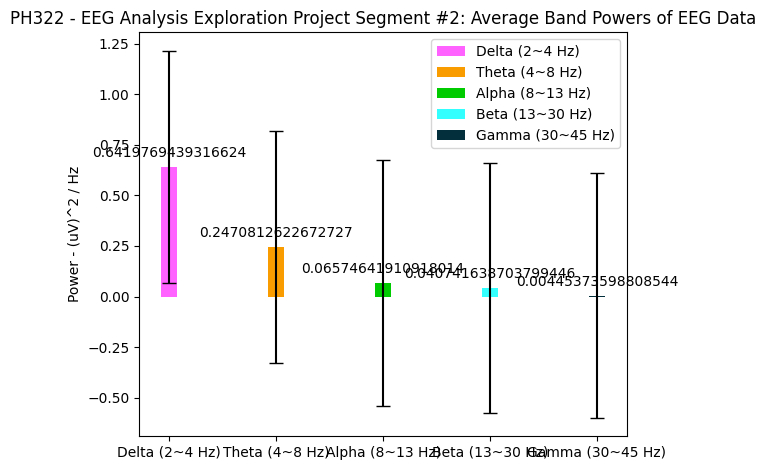

<Figure size 2000x3000 with 0 Axes>

In [30]:
### PH 322 - OpenBCI & BrainFlow EEG Data Analysis Exploration Project Segment #2: EEG Brainwaves / Average Band Powers Graphing - Dan Jang

## Credits to ChatGPT for initial EEG data processing & implementation
## Credits to BrainFlow API Docs for Python File I/O, Signal Filtering, & Band Power Examples

## Libraries
import brainflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, DetrendOperations, WindowOperations

# board_id = BoardIds.CYTON_BOARD.value
#             eeg_channels, sfreq = self._get_board_info(board_id)
#             channel_names = utils.OPENBCI_STANDARD_8

# OPENBCI_STANDARD_8 = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2',
#                       'F7' , 'F8' , 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']

# Read the BrainFlow-RAW OpenBCI Cyton Board-based 8-channel EEG dataset .csv file
eeg_data_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"
#eeg_data = pd.read_csv(eeg_data_file, sep='\t', header=None)

# Restore data from the file through DataFilter (BrainFlow), then load into a DataFrame
eeg_data = DataFilter.read_file(eeg_data_file)
df = pd.DataFrame(np.transpose(eeg_data))
#print("Loaded the following EEG data from '" + str(eeg_data_file) + "': " + str(df.head(10)))

# Initialize virtual board
params = BrainFlowInputParams()
params.ip_port = 0
params.serial_port = ''
params.mac_address = ''
params.other_info = ''
params.serial_number = ''
params.ip_address = ''
params.ip_protocol = 0
params.timeout = 0
params.file = eeg_data_file
params.master_board = BoardIds.NO_BOARD

defaultboard = BoardIds.SYNTHETIC_BOARD
streamerparams = ''

nfft = DataFilter.get_nearest_power_of_two(sampling_rate)

#idx = 5 * self.eeg_info[1]
#data = data[:, idx:]

# Remove unnecessary columns
#eeg_data = eeg_data.iloc[:, :8]

# Set up the plot
fig, ax = plt.subplots()
band_labels = ['Delta (2~4 Hz)', 'Theta (4~8 Hz)', 'Alpha (8~13 Hz)', 'Beta (13~30 Hz)', 'Gamma (30~45 Hz)']
#lines = [plt.plot([], [], animated=True, label=band)[0] for band in ['Delta (2~4 Hz)', 'Theta (4~8 Hz)', 'Alpha (8~13 Hz)', 'Beta (13~30 Hz)', 'Gamma (30~45 Hz)']]#['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']]
x = np.arange(len(band_labels))
width = 0.15

# Function to calculate band powers
def calculate_band_powers(data, channels, sampling_rate, apply_filters=True):
    eeg_data = data
    eeg_data = np.asarray(eeg_data)
    print("Channels Detected: " + str(channels))

    # Apply filters if required
    if apply_filters:
        for channel in channels:
            #eeg_data[channel] = brainflow.signal_processing.perform_bandpass(eeg_data[channel], sampling_rate, 2, 50, 4, 0)
            #eeg_data[channel] = brainflow.signal_processing.perform_bandstop(eeg_data[channel], sampling_rate, 2, 60, 4, 0)
            # eeg_data[channel] = DataFilter.perform_bandpass(eeg_data[channel], len(eeg_data[channel]), sampling_rate, 2, 50, 4, 0)
            # eeg_data[channel] = DataFilter.perform_bandstop(eeg_data[channel], len(eeg_data[channel]), sampling_rate, 2, 60, 4, 0)
            #eeg_data[channel] = DataFilter.perform_bandpass(eeg_data[channel], sampling_rate, 50.0, 4.0, 4, FilterTypes.BUTTERWORTH.value, 0)
            #eeg_data[channel] = DataFilter.perform_bandstop(eeg_data[channel], sampling_rate, 60.0, 4.0, 4, FilterTypes.BESSEL.value, 0)
            DataFilter.detrend(eeg_data[channel], DetrendOperations.LINEAR.value)
            psd = DataFilter.get_psd_welch(eeg_data[channel], nfft, nfft // 2, sampling_rate, WindowOperations.BLACKMAN_HARRIS.value)

    # Calculate average band powers
    #avg_band_powers, _ = brainflow.signal_processing.get_avg_band_powers(eeg_data, channels, sampling_rate, apply_filters)
    avg_band_powers, stddev = DataFilter.get_avg_band_powers(eeg_data, channels, sampling_rate, apply_filters)
    return avg_band_powers, stddev

# Calculate the average band powers
channels = [i for i in range(8)]  # Assuming an 8-channel EEG OpenBCI Cyton Board headset
sampling_rate = 250  # Assuming a sampling rate of 250 Hz
avg_band_powers, stddev = calculate_band_powers(eeg_data[channels], channels, sampling_rate)

print("Average band powers: " + str(avg_band_powers))
print("Standard deviation: " + str(stddev))

# # Plot the average band powers
# rects = ax.bar(x, avg_band_powers, label='Avg. Band Powers', yerr=stddev, align='center', alpha=0.5, width, ecolor='black', capsize=10)

# Plot the average band powers with distinct colors for each brainwave & also error bars showing standard deviations
#colors = ['magenta', 'orange', 'green', 'teal', 'navy blue']
colors = ['#ff62ff', '#f99c00', '#00cb00', '#33ffff', '#032f3c']
rects = [ax.bar(x[i], avg_band_powers[i], width, color=colors[i], label=band_labels[i], yerr=stddev[i], capsize=5) for i in range(len(avg_band_powers))]

# Add some text for labels, title and custom x-axis tick labels, etc.
#plt.rcParams['xtick.labelsize'] = small
ax.set_ylabel("Power - (uV)^2 / Hz")
ax.set_title("PH322 - EEG Analysis Exploration Project Segment #2: Average Band Powers of EEG Data")
ax.set_xticks(x)
ax.set_xticklabels(band_labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects)
for rect in rects:
    autolabel(rect)
    
fig.tight_layout()
fig = plt.figure(figsize=(20, 30))

plt.savefig("PH322, EEG Student Project - Code Segment #2, Average Band Powers.png")
plt.show()

## Code Segment #3: EEG-Based Generalized Rest, Concentration, or Immersion Detector Based on Band Power Ratios

Based on OpenBCI's [Focus Widget](https://github.com/OpenBCI/OpenBCI_GUI/blob/master/OpenBCI_GUI/W_Focus.pde), we can make a generalized prediction of focus vs. relaxation.

While OpenBCI's Focus Widget uses an FFT-value based, comparative generally (within & to Beta vs. Gamma), it also uses a machine-learning pre-trained model, which, if I had a little more time (if I had started this earlier), I think would have been feasible.

However, using generalized information from a cool [Research Article, "Comparison between Concentration and Immersion Based on EEG Analysis"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6479797/), I implemented a rudimentary concentration vs. relaxation detector below!

Specifically, I will be implementing (albeit, in an amateur & from glance) the findings from the above article's [Figure 4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6479797/figure/sensors-19-01669-f004/), which show the Absolute Power (uV^2) FFT (STFT specifically, as 'Short-Time Fourier Transform', post-noise removal according to the research article) transformation results of the Theta, Alpha, & Beta waves, with correlating differential ratios between these three waves, across three different states:
* Rest
* Concentration
* Immersion

However, instead of absolute power, I will be using the average band power results from Code Segment #2 (although we will still use NFFT, albeit not STFT).

### Reference:
Lim, S., Yeo, M., & Yoon, G. (2019). Comparison between Concentration and Immersion Based on EEG Analysis. Sensors (Basel, Switzerland), 19(7), 1669. https://doi.org/10.3390/s19071669



In [ ]:
### PH 322 - OpenBCI & BrainFlow EEG Data Analysis Exploration Project Segment #3: Code Segment #3: EEG-Based Generalized Rest, Concentration, or Immersion Detector Based on Band Power Ratios - Dan Jang

## Credits to ChatGPT for initial EEG data processing & implementation
## Credits to BrainFlow API Docs for Python File I/O, Signal Filtering, & Band Power Examples

## Libraries
import brainflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, DetrendOperations, WindowOperations

# board_id = BoardIds.CYTON_BOARD.value
#             eeg_channels, sfreq = self._get_board_info(board_id)
#             channel_names = utils.OPENBCI_STANDARD_8

# OPENBCI_STANDARD_8 = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2',
#                       'F7' , 'F8' , 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']

# Read the BrainFlow-RAW OpenBCI Cyton Board-based 8-channel EEG dataset .csv file
eeg_data_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"
#eeg_data = pd.read_csv(eeg_data_file, sep='\t', header=None)

# Restore data from the file through DataFilter (BrainFlow), then load into a DataFrame
eeg_data = DataFilter.read_file(eeg_data_file)
df = pd.DataFrame(np.transpose(eeg_data))
#print("Loaded the following EEG data from '" + str(eeg_data_file) + "': " + str(df.head(10)))

# Initialize virtual board
params = BrainFlowInputParams()
params.ip_port = 0
params.serial_port = ''
params.mac_address = ''
params.other_info = ''
params.serial_number = ''
params.ip_address = ''
params.ip_protocol = 0
params.timeout = 0
params.file = eeg_data_file
params.master_board = BoardIds.NO_BOARD

defaultboard = BoardIds.SYNTHETIC_BOARD
streamerparams = ''

nfft = DataFilter.get_nearest_power_of_two(sampling_rate)

# Function to calculate band powers
def calculate_band_powers(data, channels, sampling_rate, apply_filters=True):
    eeg_data = data
    eeg_data = np.asarray(eeg_data)
    print("Channels Detected: " + str(channels))

    # Apply filters if required
    if apply_filters:
        for channel in channels:
            #eeg_data[channel] = brainflow.signal_processing.perform_bandpass(eeg_data[channel], sampling_rate, 2, 50, 4, 0)
            #eeg_data[channel] = brainflow.signal_processing.perform_bandstop(eeg_data[channel], sampling_rate, 2, 60, 4, 0)
            # eeg_data[channel] = DataFilter.perform_bandpass(eeg_data[channel], len(eeg_data[channel]), sampling_rate, 2, 50, 4, 0)
            # eeg_data[channel] = DataFilter.perform_bandstop(eeg_data[channel], len(eeg_data[channel]), sampling_rate, 2, 60, 4, 0)
            #eeg_data[channel] = DataFilter.perform_bandpass(eeg_data[channel], sampling_rate, 50.0, 4.0, 4, FilterTypes.BUTTERWORTH.value, 0)
            #eeg_data[channel] = DataFilter.perform_bandstop(eeg_data[channel], sampling_rate, 60.0, 4.0, 4, FilterTypes.BESSEL.value, 0)
            DataFilter.detrend(eeg_data[channel], DetrendOperations.LINEAR.value)
            psd = DataFilter.get_psd_welch(eeg_data[channel], nfft, nfft // 2, sampling_rate, WindowOperations.BLACKMAN_HARRIS.value)

    # Calculate average band powers
    #avg_band_powers, _ = brainflow.signal_processing.get_avg_band_powers(eeg_data, channels, sampling_rate, apply_filters)
    avg_band_powers, stddev = DataFilter.get_avg_band_powers(eeg_data, channels, sampling_rate, apply_filters)
    return avg_band_powers, stddev

# Calculate the average band powers
channels = [i for i in range(8)]  # Assuming an 8-channel EEG OpenBCI Cyton Board headset
sampling_rate = 250  # Assuming a sampling rate of 250 Hz
avg_band_powers, stddev = calculate_band_powers(eeg_data[channels], channels, sampling_rate)

print("Average band powers: " + str(avg_band_powers))
print("Standard deviation: " + str(stddev))



## Conclusion

Using Python, we can analyze the EEG data and categorize the brain waves into their respective bands. We can then used the data to a create graph that showed the average band powers of each respective brain waves. This can be used to analyze the brain wave activity of a person and determine what state of mind they are in, e.g. deep concentration, relaxation, etc.

We used the Fast Fourier Transformation to process OpenBCI EEG raw data to visualize the different brain waves (Alpha, Beta, Gamma, Delta, Theta) in a graph. We can see that the brain waves are categorized into their respective bands and we can see how they change over time.

### Resources, References, & Credits

[BrainFlow API](https://brainflow.readthedocs.io/en/stable/)

Specifically, [BrainFlow API - get_avg-band_powers()](https://brainflow.readthedocs.io/en/stable/UserAPI.html?highlight=band_powers#_CPPv4N10DataFilter19get_avg_band_powersERK14BrainFlowArrayIdXL2EEENSt6vectorIiEEib), [BrainFlow API - Python Band Powers](https://brainflow.readthedocs.io/en/stable/Examples.html#python-band-power), [BrainFlow API - Python Signal Filtering](https://brainflow.readthedocs.io/en/stable/Examples.html#python-signal-filtering), & [BrainFlow API - Python Read Write File](https://brainflow.readthedocs.io/en/stable/Examples.html#python-read-write-file)

Awesome Set of BrainFlow Python Examples from [Ahnaaf Khan](https://ahnaafk.medium.com/creating-a-neurofeedback-program-with-python-c6153022a4e7) {[GitHub Repository](https://github.com/ahnaafk/neurofeedback)}

[OpenBCI Plotting GitHub](https://github.com/andreaortuno/Plotting_OpenBCI_Cyton_Data_live)

[OpenBCI Cyton](https://docs.openbci.com/Cyton/CytonLanding/)

[Research Article, "Comparison between Concentration and Immersion Based on EEG Analysis"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6479797/) on EEG-Based Concentration vs. Immersion Detection for Code Segment #3. (Lim, S., Yeo, M., & Yoon, G. (2019). Comparison between Concentration and Immersion Based on EEG Analysis. Sensors (Basel, Switzerland), 19(7), 1669. https://doi.org/10.3390/s19071669)

[OpenBCI_GUI Focus Widget](https://github.com/OpenBCI/OpenBCI_GUI/blob/master/OpenBCI_GUI/W_Focus.pde) {[OpenBCI_GUI Docs on the Focus Widget](https://docs.openbci.com/Software/OpenBCISoftware/GUIWidgets/#focus-widget)}

[pyOpenBCI](https://github.com/openbci-archive/pyOpenBCI)

[PyQtGraph](https://www.pyqtgraph.org/)

ChatGPT

[BrainFlow Notebooks](https://github.com/JadinTredup/brainflow-notebooks)

##### Extras: Commented Out Code

In [ ]:
# ### PH 322 - OpenBCI & BrainFlow EEG Data Analysis Exploration Project Segment #2: EEG Brainwaves / Average Band Powers Graphing - Dan Jang

# ## Credits to ChatGPT for EEG data processing & implementation
# ## Credits to BrainFlow API Docs for Python File I/O & Band Power Examples

# ## Libraries
# import brainflow
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from brainflow.board_shim import BoardShim, BrainFlowInputParams

# # Read the .csv file
# eeg_data_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"#eeg_data.csv"
# eeg_data = pd.read_csv(eeg_data_file)

# # Set up the plot
# fig, ax = plt.subplots()
# x_data = []
# y_data = [[] for _ in range(5)]  # 5 bands (delta, theta, alpha, beta, gamma)
# lines = [plt.plot([], [], animated=True, label=band)[0] for band in ['Delta (0.5~4 Hz)', 'Theta (4~8 Hz)', 'Alpha (8~13 Hz)', 'Beta (13~30 Hz)', 'Gamma (30~100 Hz)']]#['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']]

# # Function to initialize the plot
# def init():
#     ax.set_xlim(0, duration)
#     ax.set_ylim(0, 10)  # Adjust the y-axis range as needed
#     ax.legend()
#     return lines

# # Function to calculate band powers
# def calculate_band_powers(data, channels, sampling_rate, apply_filters=True):
#     eeg_data = data.T
#     eeg_data = np.asarray(eeg_data)

#     # Apply filters if required
#     if apply_filters:
#         for channel in channels:
#             eeg_data[channel] = brainflow.signal_processing.perform_bandpass(eeg_data[channel], sampling_rate, 2, 50, 4, 0)
#             eeg_data[channel] = brainflow.signal_processing.perform_bandstop(eeg_data[channel], sampling_rate, 2, 60, 4, 0)

#     # Calculate average band powers
#     avg_band_powers, _ = brainflow.signal_processing.get_avg_band_powers(eeg_data, channels, sampling_rate, apply_filters)
#     return avg_band_powers

# # Function to update the plot
# def update(frame):
#     x_data.append(frame)
#     channels = [i for i in range(8)]  # Assuming an 8-channel EEG OpenBCI Cyton Board headset
#     sampling_rate = 250  # Assuming a sampling rate of 250 Hz
#     band_powers = calculate_band_powers(eeg_data[channels], channels, sampling_rate)

#     for i, band_power in enumerate(band_powers):
#         y_data[i].append(band_power)
#         lines[i].set_data(x_data, y_data[i])

#     return lines

# # Calculate the duration and number of frames
# sampling_rate = 250  # Assuming a sampling rate of 250 Hz
# num_datapoints = len(eeg_data)
# duration = num_datapoints / sampling_rate
# interval = 100  # Update interval in milliseconds
# num_frames = int(duration * 1000 / interval)

# # Set up the animation
# ani = FuncAnimation(fig, update, frames=np.linspace(0, duration, num_frames),
#                     init_func=init, blit=True, interval=interval, repeat=True)

# # Display the animation
# plt.show()


# ## PH 322 - OpenBCI & BrainFlow EEG Data Analysis Exploration Project Segment #2: EEG Brainwaves / Average Band Powers Graphing - Dan Jang

# ## Credits to ChatGPT for EEG data processing & implementation
# ## Credits to BrainFlow API Docs for Python File I/O & Band Power Examples

# ## Libraries

# import brainflow as bf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from brainflow.board_shim import BoardShim, BrainFlowInputParams

# # Read the .csv file
# eeg_data_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"#eeg_data.csv"
# eeg_data = pd.read_csv(eeg_data_file)

# # Set up the plot
# fig, ax = plt.subplots()
# x_data = []
# y_data = [[] for _ in range(5)]  # 5 bands (delta, theta, alpha, beta, gamma)
# # lines = [plt.plot([], [], animated=True, label=band)[0] for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']]
# lines = [plt.plot([], [], animated=True, label=band)[0] for band in ['Delta (0.5~4 Hz)', 'Theta (4~8 Hz)', 'Alpha (8~13 Hz)', 'Beta (13~30 Hz)', 'Gamma (30~100 Hz)']]

# # Function to initialize the plot
# def init():
#     ax.set_xlim(0, 10)  # Adjust the x-axis range as needed
#     ax.set_ylim(0, 10)  # Adjust the y-axis range as needed
#     ax.legend()
#     return lines

# # Function to calculate band powers
# def calculate_band_powers(data, channels, sampling_rate, apply_filters=True):
#     eeg_data = data.T
#     eeg_data = np.asarray(eeg_data)

#     # Apply filters if required
#     if apply_filters:
#         for channel in channels:
#             eeg_data[channel] = bf.signal_processing.perform_bandpass(eeg_data[channel], sampling_rate, 2, 50, 4, 0)
#             eeg_data[channel] = bf.signal_processing.perform_bandstop(eeg_data[channel], sampling_rate, 2, 60, 4, 0)

#     # Calculate average band powers
#     avg_band_powers, _ = bf.signal_processing.get_avg_band_powers(eeg_data, channels, sampling_rate, apply_filters)
#     return avg_band_powers

# # Function to update the plot
# def update(frame):
#     x_data.append(frame)
#     channels = [i for i in range(8)]  # Assuming an 8-channel EEG OpenBCI Cyton Board headset
#     sampling_rate = 250  # Assuming a sampling rate of 250 Hz
    
#     #y_data.append(np.sin(frame))
    
#     ### From BrainFlow API Docs:
#     ## std::pair<double*, double*> get_avg_band_powers(const BrainFlowArray<double, 2> &data, std::vector<int> channels, int sampling_rate, bool apply_filters)
#     # calculate avg and stddev of BandPowers across all channels
#     ## Return:
#     # pair of double arrays of size 5, first of them - avg band powers, second stddev
#     ## Parameters -
#     # data: input 2d array
#     # cols: number of cols in 2d array - number of datapoints
#     # channels: vector of rows - eeg channels which should be used
#     # sampling_rate: sampling rate
#     # apply_filters: set to true to apply filters before band power calculations
#     #bf.get_avg_band_powers(eeg_data, 1, 250, True)
    
#     #y_data.append(bf.get_avg_band_powers(eeg_data, 1, 250, True))
#     band_powers = bf.calculate_band_powers(eeg_data[channels], channels, sampling_rate)

#     for i, band_power in enumerate(band_powers):
#         y_data[i].append(band_power)
#         lines[i].set_data(x_data, y_data[i])

#     return lines

# # Set up the animation
# ani = FuncAnimation(fig, update, frames=np.linspace(0, 10, 100),  # Adjust the frames range as needed
#                     init_func=init, blit=True, interval=100, repeat=True)

# # Display the animation
# plt.show()


# import numpy as np
# import pandas as pd
# import mne
# #from mne.time_frequency import psd_welch
# from mayavi import mlab
# import time

# # Step 1: Read the BrainFlow-RAW .csv file
# file_name = "data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"
# raw_data = pd.read_csv(file_name, header=None).values.T
# n_channels = 8
# sampling_rate = 250  # Adjust based on the sampling rate of your data

# # Step 2: Pre-process the EEG data
# # Create an MNE info object for the raw data
# ch_names = [f"E{i + 1}" for i in range(n_channels)] + ["STI 014"]
# ch_types = ["eeg" for _ in range(n_channels)] + ["stim"]
# info = mne.create_info(ch_names=ch_names,
#                        sfreq=sampling_rate,
#                        ch_types=ch_types)

# # Create MNE raw object
# raw = mne.io.RawArray(raw_data, info)
# raw.set_eeg_reference("average", projection=True)  # Set EEG average reference

# # Filter the data
# raw.filter(1, 50)  # Filter between 1 Hz and 50 Hz


# # Step 3: Calculate the band powers
# def get_band_powers(raw_data, n_channels):
#     # Define frequency bands
#     freq_bands = {
#         "delta": [1, 4],
#         "theta": [4, 8],
#         "alpha": [8, 14],
#         "beta": [14, 30],
#         "gamma": [30, 50]
#     }
#     band_powers = []

#     # Calculate power spectral density (PSD) using Welch's method
#     psds, freqs = psd_welch(raw_data, fmin=1, fmax=50)

#     # Normalize PSDs
#     psds /= np.sum(psds, axis=-1, keepdims=True)

#     # Calculate band powers for each channel
#     for ch_idx in range(n_channels):
#         band_powers.append([
#             np.sum(psds[ch_idx, (freqs >= low) & (freqs <= high)])
#             for low, high in freq_bands.values()
#         ])

#     return np.array(band_powers)


# # Step 4: Visualize the band powers in a 3D live stream
# def visualize_band_powers(band_powers):
#     # Create a 3D bar plot
#     fig = mlab.figure(size=(600, 600))
#     x, y = np.mgrid[0:8:1, 0:5:1]
#     s = mlab.barchart(x, y, band_powers.T, figure=fig)

#     while True:
#         # Update the band powers
#         band_powers = get_band_powers(raw[:, :][0], n_channels)

#         # Update the 3D bar plot
#         s.mlab_source.scalars = band_powers.T
#         mlab.draw(fig)
#         time.sleep(0.1)


# if __name__ == "__main__":
#     band_powers = get_band_powers(raw[:, :][0], n_channels)
#     visualize_band_powers(band_powers)

# import sys
# import numpy as np
# import pandas as pd
# from PyQt5.QtWidgets import QApplication, QMainWindow
# import pyqtgraph as pg
# import pyqtgraph.opengl as gl
# from scipy.fft import fft

# # Load CSV data
# def load_csv_data(file_path):
#     data = pd.read_csv(file_path, header=None)
#     return data

# # Preprocess EEG data and extract frequency bands
# def preprocess_eeg_data(data, sample_rate=250):
#     # Define frequency bands
#     bands = {
#         'delta': (0.5, 4),
#         'theta': (4, 8),
#         'alpha': (8, 13),
#         'beta': (13, 30),
#         'gamma': (30, 100)
#     }

#     # Extract data from each channel
#     channels_data = [data.iloc[:, i].values for i in range(1, 9)]

#     # Calculate FFT for each channel
#     fft_data = [np.abs(fft(channel_data)) for channel_data in channels_data]
#     freqs = np.fft.fftfreq(len(channels_data[0]), 1 / sample_rate)

#     # Calculate average power in each frequency band for each channel
#     band_data = []
#     for i, channel_fft in enumerate(fft_data):
#         band_powers = []
#         for band_name, (low_freq, high_freq) in bands.items():
#             mask = (freqs >= low_freq) & (freqs <= high_freq)
#             band_power = np.mean(channel_fft[mask])
#             band_powers.append(band_power)

#         band_data.append({'channel': i + 1, 'band_powers': band_powers})

#     return band_data

# # Plot 3D band data
# def plot_band_data(data):
#     # Create the PyQt5 application and main window
#     app = QApplication(sys.argv)
#     main_window = QMainWindow()
#     main_window.setWindowTitle('3D Band Plot')

#     # Create a 3D OpenGL plot widget
#     plot_widget = gl.GLViewWidget()
#     plot_widget.setBackgroundColor('w')
#     main_window.setCentralWidget(plot_widget)

#     # Preprocess the EEG data and extract the frequency bands
#     band_data = preprocess_eeg_data(data)

#     # Plot the frequency bands in 3D using the OpenGL plot widget
#     # Depending on your data format, you may need to adjust the coordinates and color
#     for band in band_data:
#         x, y, z, color = band['x'], band['y'], band['z'], band['color']
#         scatter_plot_item = gl.GLScatterPlotItem(pos=np.array([x, y, z]),
#                                                  color=color,
#                                                  size=10)
#         plot_widget.addItem(scatter_plot_item)

#     # Show the main window and start the PyQt5 event loop
#     main_window.show()
#     sys.exit(app.exec_())

# if __name__ == '__main__':
#     file_path = 'OpenBCISession_2023-03-02_19-06-28/BrainFlow-RAW_2023-03-02_19-06-28_0.csv'
#     data = load_csv_data(file_path)
#     plot_band_data(data)

# ### PH 322 - Project - Dan Jang
# ## Credits to ChatGPT for EEG data processing & implementation

# ## Libraries

# import brainflow as bf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from brainflow.board_shim import BoardShim, BrainFlowInputParams

# # Read the .csv file
# eeg_data_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"#eeg_data.csv"
# eeg_data = pd.read_csv(eeg_data_file)

# # Set up the plot
# fig, ax = plt.subplots()
# x_data = []
# y_data = [[] for _ in range(5)]  # 5 bands (delta, theta, alpha, beta, gamma)
# # lines = [plt.plot([], [], animated=True, label=band)[0] for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']]
# lines = [plt.plot([], [], animated=True, label=band)[0] for band in ['Delta (0.5~4 Hz)', 'Theta (4~8 Hz)', 'Alpha (8~13 Hz)', 'Beta (13~30 Hz)', 'Gamma (30~100 Hz)']]

# # Function to initialize the plot
# def init():
#     ax.set_xlim(0, 10)  # Adjust the x-axis range as needed
#     ax.set_ylim(0, 10)  # Adjust the y-axis range as needed
#     ax.legend()
#     return lines

# # Function to calculate band powers
# def calculate_band_powers(data, channels, sampling_rate, apply_filters=True):
#     eeg_data = data.T
#     eeg_data = np.asarray(eeg_data)

#     # Apply filters if required
#     if apply_filters:
#         for channel in channels:
#             eeg_data[channel] = bf.signal_processing.perform_bandpass(eeg_data[channel], sampling_rate, 2, 50, 4, 0)
#             eeg_data[channel] = bf.signal_processing.perform_bandstop(eeg_data[channel], sampling_rate, 2, 60, 4, 0)

#     # Calculate average band powers
#     avg_band_powers, _ = bf.signal_processing.get_avg_band_powers(eeg_data, channels, sampling_rate, apply_filters)
#     return avg_band_powers

# # Function to update the plot
# def update(frame):
#     x_data.append(frame)
#     channels = [i for i in range(8)]  # Assuming an 8-channel EEG OpenBCI Cyton Board headset
#     sampling_rate = 250  # Assuming a sampling rate of 250 Hz
    
#     #y_data.append(np.sin(frame))
    
#     ### From BrainFlow API Docs:
#     ## std::pair<double*, double*> get_avg_band_powers(const BrainFlowArray<double, 2> &data, std::vector<int> channels, int sampling_rate, bool apply_filters)
#     # calculate avg and stddev of BandPowers across all channels
#     ## Return:
#     # pair of double arrays of size 5, first of them - avg band powers, second stddev
#     ## Parameters -
#     # data: input 2d array
#     # cols: number of cols in 2d array - number of datapoints
#     # channels: vector of rows - eeg channels which should be used
#     # sampling_rate: sampling rate
#     # apply_filters: set to true to apply filters before band power calculations
#     #bf.get_avg_band_powers(eeg_data, 1, 250, True)
    
#     #y_data.append(bf.get_avg_band_powers(eeg_data, 1, 250, True))
#     band_powers = bf.calculate_band_powers(eeg_data[channels], channels, sampling_rate)

#     for i, band_power in enumerate(band_powers):
#         y_data[i].append(band_power)
#         lines[i].set_data(x_data, y_data[i])

#     return lines

# # Set up the animation
# ani = FuncAnimation(fig, update, frames=np.linspace(0, 10, 100),  # Adjust the frames range as needed
#                     init_func=init, blit=True, interval=100, repeat=True)

# # Display the animation
# plt.show()


# import brainflow as bf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from brainflow.board_shim import BoardShim, BrainFlowInputParams

# # Read the .csv file
# eeg_data_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"#eeg_data_file = "eeg_data.csv"
# eeg_data = pd.read_csv(eeg_data_file, delimiter='\t', header=None)

# # Set column names
# column_names = [str(i) for i in range(eeg_data.shape[1])]
# eeg_data.columns = column_names

# # Function to calculate band powers
# def calculate_band_powers(data, channels, sampling_rate, apply_filters=True):
#     eeg_data = data[channels].values.T
#     eeg_data = np.asarray(eeg_data)

#     # Apply filters if required
#     if apply_filters:
#         for channel in range(len(channels)):
#             eeg_data[channel] = bf.signal_processing.perform_bandpass(eeg_data[channel], sampling_rate, 2, 50, 4, 0)
#             eeg_data[channel] = bf.signal_processing.perform_bandstop(eeg_data[channel], sampling_rate, 2, 60, 4, 0)

#     # Calculate average band powers
#     avg_band_powers, _ = bf.signal_processing.get_avg_band_powers(eeg_data, list(range(len(channels))), sampling_rate, apply_filters)
#     return avg_band_powers


# # Calculate the duration
# sampling_rate = 250  # Assuming a sampling rate of 250 Hz
# num_datapoints = len(eeg_data)
# duration = num_datapoints / sampling_rate

# # Set up the plot
# fig, ax = plt.subplots()
# bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
# x_data = np.linspace(0, duration, num_datapoints)
# y_data = [[] for _ in range(5)]  # 5 bands (delta, theta, alpha, beta, gamma)

# # Calculate band powers for each time step
# channels = [i for i in range(8)]  # Assuming an 8-channel EEG OpenBCI Cyton Board headset
# for i in range(num_datapoints):
#     band_powers = calculate_band_powers(eeg_data.iloc[[i]][channels], channels, sampling_rate)
#     for j, band_power in enumerate(band_powers):
#         y_data[j].append(band_power)

# # Plot the band powers over the total duration
# for i, band in enumerate(bands):
#     plt.plot(x_data, y_data[i], label=band)

# # Set axis labels and legend
# plt.xlabel("Time (s)")
# plt.ylabel("Band Power")
# plt.legend()

# # Display the plot
# plt.show()

# pip install vext.pyqt5

# pip install arabic_reshaper astunparse distro esprima freetype-py future geventgitpython glfw imageio imageio-ffmpeg javascripthon json_tricks moviepy msgpack msgpack-numpy opencv-python openpyxl pillow psutil pyglet pyopengl pyosf pyparallel pyserial python-bidi python-gitlab pyyaml questplus requests[security] sounddevice soundfile tables xlrd

# pip install psychopy --no-deps

# ### PH 322 - OpenBCI & BrainFlow EEG Data Analysis Exploration Project: Livestream Segment - Dan Jang1
# ## Credits to BrainFlow API Docs for Python File I/O & Band Power Examples
# ## Credits to ChatGPT for being able to modify the depreciated PyQtGraph example to a interactive & importantly. Jupyter Notebook compatible plot using matplotlib!


# ## Libraries
# #import argparse
# import logging
# import numpy as np
# import matplotlib.pyplot as plt
# from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, WindowOperations, DetrendOperations
# from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
# from IPython import display

# csv_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"

# class Graph:
#     def __init__(self, board_shim):
#         self.board_id = board_shim.get_board_id()
#         self.board_shim = board_shim
#         self.exg_channels = BoardShim.get_exg_channels(self.board_id)
#         self.sampling_rate = BoardShim.get_sampling_rate(self.board_id)
#         self.update_speed_ms = 50
#         self.window_size = 4
#         self.num_points = self.window_size * self.sampling_rate

#         self.fig, self.axes = plt.subplots(len(self.exg_channels), 1, figsize=(8, 6))

#         for ax in self.axes:
#             ax.set_xticks([])
#             ax.set_yticks([])

#         self.update()

#     def update(self):
#         data = self.board_shim.get_current_board_data(self.num_points)
#         for count, channel in enumerate(self.exg_channels):
#             # plot timeseries
#             DataFilter.detrend(data[channel], DetrendOperations.CONSTANT.value)
#             DataFilter.perform_bandpass(data[channel], self.sampling_rate, 3.0, 45.0, 2,
#                                         FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
#             DataFilter.perform_bandstop(data[channel], self.sampling_rate, 48.0, 52.0, 2,
#                                         FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
#             DataFilter.perform_bandstop(data[channel], self.sampling_rate, 58.0, 62.0, 2,
#                                         FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
#             self.axes[count].plot(data[channel].tolist(), 'b')
#             self.axes[count].set_xlim(0, self.num_points)

#         display.display(self.fig)
#         display.clear_output(wait=True)

# def main():
#     BoardShim.enable_dev_board_logger()
#     logging.basicConfig(level=logging.DEBUG)

#     params = BrainFlowInputParams()
#     params.ip_port = 0
#     params.serial_port = ''
#     params.mac_address = ''
#     params.other_info = ''
#     params.serial_number = ''
#     params.ip_address = ''
#     params.ip_protocol = 0
#     params.timeout = 0
#     params.file = csv_file
#     params.master_board = BoardIds.NO_BOARD
    
#     defaultboard = BoardIds.SYNTHETIC_BOARD
#     streamerparams = ''

#     board_shim = BoardShim(defaultboard, params)
#     try:
#         board_shim.prepare_session()
#         board_shim.start_stream(450000, streamerparams)
#         Graph(board_shim)
#     except BaseException:
#         logging.warning('Exception', exc_info=True)
#     finally:
#         logging.info('End')
#         if board_shim.is_prepared():
#             logging.info('Releasing session')
#             board_shim.release_session()

# # Run the main function in the Jupyter Notebook
# %matplotlib notebook
# main()

# ### PH 322 - OpenBCI & BrainFlow EEG Data Analysis Exploration Project: Livestream Segment - Dan Jang
# ## Credits to BrainFlow API Docs for Python File I/O & Band Power Examples

# ## Libraries
# #import argparse
# import logging
# import pyqtgraph as pg
# import numpy as np
# from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations
# from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
# from pyqtgraph.Qt import QtGui, QtCore

# csv_file = "./data/BrainFlow-RAW_2023-03-02_19-06-28_0.csv"

# class Graph:
#     def __init__(self, board_shim):
#         self.board_id = board_shim.get_board_id()
#         self.board_shim = board_shim
#         self.exg_channels = BoardShim.get_exg_channels(self.board_id)
#         self.sampling_rate = BoardShim.get_sampling_rate(self.board_id)
#         self.update_speed_ms = 50
#         self.window_size = 4
#         self.num_points = self.window_size * self.sampling_rate

#         self.app = QtGui.QApplication([])
#         self.win = pg.GraphicsWindow(title='BrainFlow Plot', size=(800, 600))

#         self._init_timeseries()

#         timer = QtCore.QTimer()
#         timer.timeout.connect(self.update)
#         timer.start(self.update_speed_ms)

#     def _init_timeseries(self):
#         self.plots = list()
#         self.curves = list()
#         for i in range(len(self.exg_channels)):
#             p = self.win.addPlot(row=i, col=0)
#             p.showAxis('left', False)
#             p.setMenuEnabled('left', False)
#             p.showAxis('bottom', False)
#             p.setMenuEnabled('bottom', False)
#             if i == 0:
#                 p.setTitle('TimeSeries Plot')
#             self.plots.append(p)
#             curve = p.plot()
#             self.curves.append(curve)

#     def update(self):
#         data = self.board_shim.get_current_board_data(self.num_points)
#         for count, channel in enumerate(self.exg_channels):
#             DataFilter.detrend(data[channel], DetrendOperations.CONSTANT.value)
#             DataFilter.perform_bandpass(data[channel], self.sampling_rate, 3.0, 45.0, 2,
#                                         FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
#             DataFilter.perform_bandstop(data[channel], self.sampling_rate, 48.0, 52.0, 2,
#                                         FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
#             DataFilter.perform_bandstop(data[channel], self.sampling_rate, 58.0, 62.0, 2,
#                                         FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
#             self.curves[count].setData(data[channel].tolist())

#         self.app.processEvents()

# def main():
#     BoardShim.enable_dev_board_logger()
#     logging.basicConfig(level=logging.DEBUG)

#     params = BrainFlowInputParams()
#     params.ip_port = 0
#     params.serial_port = ''
#     params.mac_address = ''
#     params.other_info = ''
#     params.serial_number = ''
#     params.ip_address = ''
#     params.ip_protocol = 0
#     params.timeout = 0
#     params.file = csv_file
#     params.master_board = BoardIds.NO_BOARD
    
#     defaultboard = BoardIds.SYNTHETIC_BOARD
#     streamerparams = ''

#     board_shim = BoardShim(defaultboard, params)
#     try:
#         board_shim.prepare_session()
#         board_shim.start_stream(450000, streamerparams)
#         Graph(board_shim)
#     except BaseException:
#         logging.warning('Exception', exc_info=True)
#     finally:
#         logging.info('End')
#         if board_shim.is_prepared():
#             logging.info('Releasing session')
#             board_shim.release_session()

# # Run the main function in the Jupyter Notebook
# %gui qt
# main()